In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
original_dataset_dir = "dataset"
base_dir = "animal_dataset_split"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    os.makedirs(test_dir)

    classes = [d for d in os.listdir(original_dataset_dir)
               if os.path.isdir(os.path.join(original_dataset_dir, d))]

    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls))
        os.makedirs(os.path.join(val_dir, cls))
        os.makedirs(os.path.join(test_dir, cls))

        files = [f for f in os.listdir(os.path.join(original_dataset_dir, cls))
                 if os.path.isfile(os.path.join(original_dataset_dir, cls, f))]
        random.shuffle(files)

        train_split = int(0.8 * len(files))
        val_split = int(0.9 * len(files))

        train_files = files[:train_split]
        val_files = files[train_split:val_split]
        test_files = files[val_split:]

        for f in train_files:
            shutil.copy(os.path.join(original_dataset_dir, cls, f), os.path.join(train_dir, cls))
        for f in val_files:
            shutil.copy(os.path.join(original_dataset_dir, cls, f), os.path.join(val_dir, cls))
        for f in test_files:
            shutil.copy(os.path.join(original_dataset_dir, cls, f), os.path.join(test_dir, cls))

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7697 images belonging to 5 classes.
Found 967 images belonging to 5 classes.
Found 962 images belonging to 5 classes.


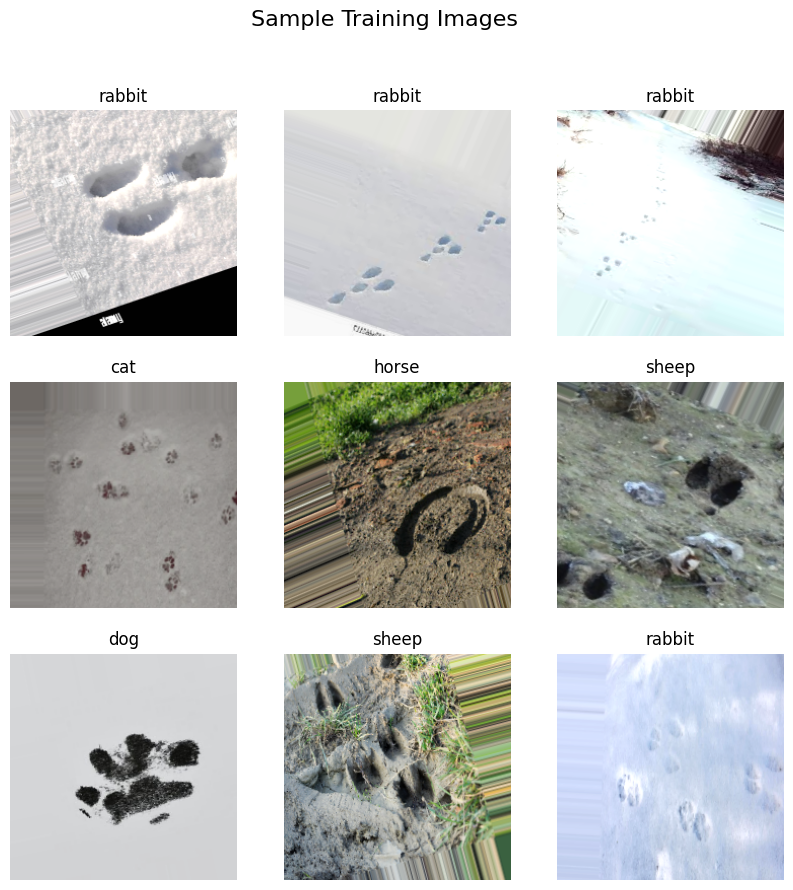

In [4]:
sample_imgs, sample_labels = next(train_gen)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_imgs[i])
    plt.title(list(train_gen.class_indices.keys())[np.argmax(sample_labels[i])])
    plt.axis("off")
plt.suptitle("Sample Training Images", fontsize=16)
plt.show()

In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [6]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),

    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,109,957 (57.64 MB)

 Trainable params: 395,269 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6),
    ModelCheckpoint("best_vgg16_animal.h5", save_best_only=True, monitor='val_loss', mode='min')
]

In [8]:
print("\n Stage 1: Training the top layers (feature extraction)...\n")
history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)


 Stage 1: Training the top layers (feature extraction)...



/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2898 - loss: 2.3581

241/241 ━━━━━━━━━━━━━━━━━━━━ 837s 3s/step - accuracy: 0.3442 - loss: 2.1682 - val_accuracy: 0.5109 - val_loss: 1.8365 - learning_rate: 1.0000e-04
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4491 - loss: 1.8255

241/241 ━━━━━━━━━━━━━━━━━━━━ 865s 4s/step - accuracy: 0.4747 - loss: 1.7504 - val_accuracy: 0.5553 - val_loss: 1.5738 - learning_rate: 1.0000e-04
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5269 - loss: 1.5935

241/241 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.5338 - loss: 1.5495 - val_accuracy: 0.5863 - val_loss: 1.4119 - learning_rate: 1.0000e-04
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5633 - loss: 1.4537

241/241 ━━━━━━━━━━━━━━━━━━━━ 1034s 4s/step - accuracy: 0.5726 - loss: 1.4319 - val_accuracy: 0.6412 - val_loss: 1.2974 - learning_rate: 1.0000e-04
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5872 - loss: 1.3652

241/241 ━━━━━━━━━━━━━━━━━━━━ 910s 4s/step - accuracy: 0.5984 - loss: 1.3380 - val_accuracy: 0.6277 - val_loss: 1.2318 - learning_rate: 1.0000e-04
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6108 - loss: 1.2935

241/241 ━━━━━━━━━━━━━━━━━━━━ 796s 3s/step - accuracy: 0.6230 - loss: 1.2722 - val_accuracy: 0.6577 - val_loss: 1.1780 - learning_rate: 1.0000e-04
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6479 - loss: 1.2246

241/241 ━━━━━━━━━━━━━━━━━━━━ 841s 3s/step - accuracy: 0.6490 - loss: 1.2161 - val_accuracy: 0.6856 - val_loss: 1.1110 - learning_rate: 1.0000e-04
Epoch 8/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6514 - loss: 1.1817

241/241 ━━━━━━━━━━━━━━━━━━━━ 875s 4s/step - accuracy: 0.6609 - loss: 1.1638 - val_accuracy: 0.6929 - val_loss: 1.0725 - learning_rate: 1.0000e-04
Epoch 9/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6832 - loss: 1.1265

241/241 ━━━━━━━━━━━━━━━━━━━━ 849s 4s/step - accuracy: 0.6836 - loss: 1.1177 - val_accuracy: 0.7166 - val_loss: 1.0309 - learning_rate: 1.0000e-04
Epoch 10/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6880 - loss: 1.0890

241/241 ━━━━━━━━━━━━━━━━━━━━ 834s 3s/step - accuracy: 0.6865 - loss: 1.0874 - val_accuracy: 0.7198 - val_loss: 1.0143 - learning_rate: 1.0000e-04
Epoch 11/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7007 - loss: 1.0696

241/241 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.7018 - loss: 1.0547 - val_accuracy: 0.7394 - val_loss: 0.9648 - learning_rate: 1.0000e-04
Epoch 12/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6876 - loss: 1.0705

241/241 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.7088 - loss: 1.0337 - val_accuracy: 0.7260 - val_loss: 0.9520 - learning_rate: 1.0000e-04
Epoch 13/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7067 - loss: 1.0223

241/241 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - accuracy: 0.7153 - loss: 1.0085 - val_accuracy: 0.7487 - val_loss: 0.9353 - learning_rate: 1.0000e-04
Epoch 14/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7158 - loss: 0.9860

241/241 ━━━━━━━━━━━━━━━━━━━━ 832s 3s/step - accuracy: 0.7224 - loss: 0.9824 - val_accuracy: 0.7642 - val_loss: 0.8940 - learning_rate: 1.0000e-04
Epoch 15/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7250 - loss: 0.9834

241/241 ━━━━━━━━━━━━━━━━━━━━ 812s 3s/step - accuracy: 0.7315 - loss: 0.9671 - val_accuracy: 0.7746 - val_loss: 0.8504 - learning_rate: 1.0000e-04
Epoch 16/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7410 - loss: 0.9348

241/241 ━━━━━━━━━━━━━━━━━━━━ 783s 3s/step - accuracy: 0.7441 - loss: 0.9302 - val_accuracy: 0.7932 - val_loss: 0.8291 - learning_rate: 1.0000e-04
Epoch 17/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7509 - loss: 0.9116

241/241 ━━━━━━━━━━━━━━━━━━━━ 837s 3s/step - accuracy: 0.7508 - loss: 0.9131 - val_accuracy: 0.7880 - val_loss: 0.8142 - learning_rate: 1.0000e-04
Epoch 18/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 896s 4s/step - accuracy: 0.7522 - loss: 0.9037 - val_accuracy: 0.7983 - val_loss: 0.8184 - learning_rate: 1.0000e-04
Epoch 19/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7595 - loss: 0.8766

241/241 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.7609 - loss: 0.8715 - val_accuracy: 0.7994 - val_loss: 0.7986 - learning_rate: 1.0000e-04
Epoch 20/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1023s 4s/step - accuracy: 0.7574 - loss: 0.8723 - val_accuracy: 0.7859 - val_loss: 0.8048 - learning_rate: 1.0000e-04
Epoch 21/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7656 - loss: 0.8543

241/241 ━━━━━━━━━━━━━━━━━━━━ 1078s 4s/step - accuracy: 0.7707 - loss: 0.8464 - val_accuracy: 0.7932 - val_loss: 0.7805 - learning_rate: 1.0000e-04
Epoch 22/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7783 - loss: 0.8301

241/241 ━━━━━━━━━━━━━━━━━━━━ 1268s 5s/step - accuracy: 0.7798 - loss: 0.8243 - val_accuracy: 0.8128 - val_loss: 0.7337 - learning_rate: 1.0000e-04
Epoch 23/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 857s 4s/step - accuracy: 0.7841 - loss: 0.8143 - val_accuracy: 0.8097 - val_loss: 0.7346 - learning_rate: 1.0000e-04
Epoch 24/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7894 - loss: 0.7947

241/241 ━━━━━━━━━━━━━━━━━━━━ 957s 4s/step - accuracy: 0.7874 - loss: 0.8075 - val_accuracy: 0.8263 - val_loss: 0.7145 - learning_rate: 1.0000e-04
Epoch 25/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7927 - loss: 0.7978

241/241 ━━━━━━━━━━━━━━━━━━━━ 1065s 4s/step - accuracy: 0.7900 - loss: 0.7898 - val_accuracy: 0.8252 - val_loss: 0.6964 - learning_rate: 1.0000e-04


In [9]:
print("\nStage 2: Fine-tuning top VGG16 layers...\n")

# Unfreeze last 4 convolutional blocks for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Stage 2: Fine-tuning top VGG16 layers...

Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7879 - loss: 0.7630 

241/241 ━━━━━━━━━━━━━━━━━━━━ 2541s 11s/step - accuracy: 0.8264 - loss: 0.6716 - val_accuracy: 0.9018 - val_loss: 0.4902 - learning_rate: 1.0000e-05
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8881 - loss: 0.5214

241/241 ━━━━━━━━━━━━━━━━━━━━ 1604s 7s/step - accuracy: 0.9009 - loss: 0.4949 - val_accuracy: 0.9421 - val_loss: 0.3834 - learning_rate: 1.0000e-05
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9313 - loss: 0.4299

241/241 ━━━━━━━━━━━━━━━━━━━━ 1668s 7s/step - accuracy: 0.9356 - loss: 0.4162 - val_accuracy: 0.9514 - val_loss: 0.3558 - learning_rate: 1.0000e-05
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9380 - loss: 0.3986

241/241 ━━━━━━━━━━━━━━━━━━━━ 1518s 6s/step - accuracy: 0.9406 - loss: 0.3926 - val_accuracy: 0.9772 - val_loss: 0.2957 - learning_rate: 1.0000e-05
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9641 - loss: 0.3497

241/241 ━━━━━━━━━━━━━━━━━━━━ 1376s 6s/step - accuracy: 0.9621 - loss: 0.3473 - val_accuracy: 0.9886 - val_loss: 0.2751 - learning_rate: 1.0000e-05
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9618 - loss: 0.3333

241/241 ━━━━━━━━━━━━━━━━━━━━ 1358s 6s/step - accuracy: 0.9675 - loss: 0.3215 - val_accuracy: 0.9907 - val_loss: 0.2686 - learning_rate: 1.0000e-05
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1476s 6s/step - accuracy: 0.9743 - loss: 0.3083 - val_accuracy: 0.9752 - val_loss: 0.2822 - learning_rate: 1.0000e-05
Epoch 8/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9753 - loss: 0.3011

241/241 ━━━━━━━━━━━━━━━━━━━━ 1429s 6s/step - accuracy: 0.9775 - loss: 0.2970 - val_accuracy: 0.9990 - val_loss: 0.2457 - learning_rate: 1.0000e-05
Epoch 9/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9823 - loss: 0.2867

241/241 ━━━━━━━━━━━━━━━━━━━━ 1370s 6s/step - accuracy: 0.9827 - loss: 0.2873 - val_accuracy: 0.9948 - val_loss: 0.2424 - learning_rate: 1.0000e-05
Epoch 10/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1448s 6s/step - accuracy: 0.9853 - loss: 0.2704 - val_accuracy: 0.9959 - val_loss: 0.2465 - learning_rate: 1.0000e-05
Epoch 11/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9834 - loss: 0.2782

241/241 ━━━━━━━━━━━━━━━━━━━━ 1652s 7s/step - accuracy: 0.9838 - loss: 0.2758 - val_accuracy: 0.9990 - val_loss: 0.2312 - learning_rate: 1.0000e-05
Epoch 12/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1683s 7s/step - accuracy: 0.9901 - loss: 0.2610 - val_accuracy: 0.9938 - val_loss: 0.2353 - learning_rate: 1.0000e-05
Epoch 13/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1403s 6s/step - accuracy: 0.9887 - loss: 0.2568 - val_accuracy: 0.9979 - val_loss: 0.2342 - learning_rate: 1.0000e-05
Epoch 14/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1547s 6s/step - accuracy: 0.9892 - loss: 0.2553 - val_accuracy: 0.9938 - val_loss: 0.2346 - learning_rate: 1.0000e-05
Epoch 15/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9892 - loss: 0.2500

241/241 ━━━━━━━━━━━━━━━━━━━━ 1481s 6s/step - accuracy: 0.9923 - loss: 0.2441 - val_accuracy: 0.9979 - val_loss: 0.2240 - learning_rate: 1.0000e-05


In [10]:
def combine_history(h1, h2):
    hist = {}
    for key in h1.history.keys():
        hist[key] = h1.history[key] + h2.history[key]
    return hist

history = combine_history(history_stage1, history_stage2)

In [11]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9938 - loss: 0.2286
Final Test Accuracy: 99.38%


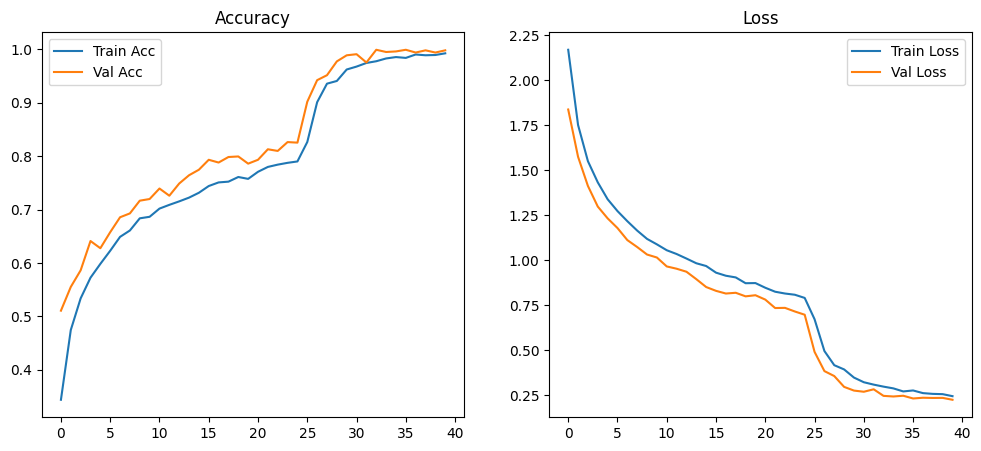

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step


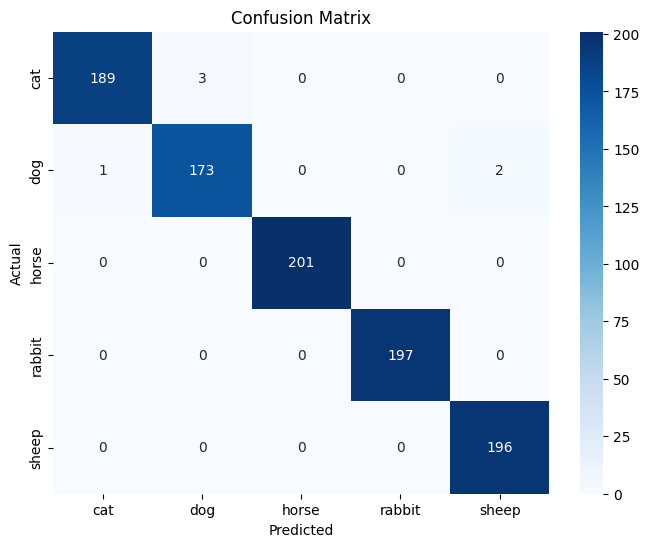

In [13]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()),
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
print("Classification Report:")
print(classification_report(
    test_gen.classes,
    y_pred_classes,
    target_names=list(test_gen.class_indices.keys())
))

Classification Report:
              precision    recall  f1-score   support

         cat       0.99      0.98      0.99       192
         dog       0.98      0.98      0.98       176
       horse       1.00      1.00      1.00       201
      rabbit       1.00      1.00      1.00       197
       sheep       0.99      1.00      0.99       196

    accuracy                           0.99       962
   macro avg       0.99      0.99      0.99       962
weighted avg       0.99      0.99      0.99       962



In [15]:
model.save("vgg16_animal_footprints_finetuned.h5")
print("Final model saved as 'vgg16_animal_footprints_finetuned.h5'")

Final model saved as 'vgg16_animal_footprints_finetuned.h5'
